In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def simulate(angles, r_spikes, l_spikes, diff, ratio, sim_times, tones, tone_errors, capacities):
    
    for l in range(len(sim_times)):
        sim_time = sim_times[l]
                   
        for s in range(len(tones)):
            tone = tones[s]
            tone_error = tone_errors[s]
            Cm_bushy = capacities[s]
            
            for y in range(len(angles)):
                nest.ResetKernel()
                nest.local_num_threads = 16
                nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°
                angle = angles[y]
                max_ild = 2
                mean_amplitude = 1000

                ANFs2SBCs_weight = 2.0
                ANFs2GBCs_weight = 1.0
                GBCs2MNTBCs_weight = 16.0
                SBCs2LSO_weight = 16.0
                MNTBCs2LSO_weight = -2.0
                
                delay = 0.1
                noise_rate = 20
                mean_rate = 0
                
                n_ANFs = 35000
                ANFs2SBCs = 4
                ANFs2GBCs = 20
                n_SBCs = int(n_ANFs/ANFs2SBCs)
                n_GBCs = int(n_ANFs/ANFs2GBCs)

                freq = np.round(np.logspace(np.log(20),np.log(20000),num = 3500, base = np.exp(1)),2)

                spectro = np.zeros((3500,sim_time))
                channels = len(freq[np.where((freq>tone-tone_error) & (freq<tone+tone_error))])
                amplitudes = stats.norm.pdf(np.linspace(-1, 1, channels) , 0, 1.0/(math.sqrt(2*math.pi)*1))
                spectro[np.where(freq>tone-tone_error)[0][0]:np.where((freq<tone+tone_error))[0][-1]+1, :] = amplitudes.reshape(channels,1)*np.ones((channels, sim_time))

                w_head = 22 #cm
                v_sound = 33000 #cm/s
                delta_x = (w_head*np.sin(np.deg2rad(angle)))
                itd = 1000*delta_x/v_sound #ms
                ipds = 2*np.pi*itd*freq/1000
                ild = angle*max_ild/90

                # Populations

                r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                        params={'frequency': np.repeat(freq, 10),
                                'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

                r_ANFs = nest.Create('parrot_neuron',n_ANFs)

                r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                        params={'frequency': np.repeat(freq, 10),
                            'phase': 0})

                l_ANFs = nest.Create('parrot_neuron',n_ANFs)

                l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': Cm_bushy, 'V_m': -70})

                ANFs_noise = nest.Create('poisson_generator',1,
                             params = {'rate':noise_rate})

                s_rec_r = nest.Create('spike_recorder')
                s_rec_l = nest.Create('spike_recorder')

                nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
                nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

                nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
                nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

                nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
                nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

                nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
                nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

                nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
                nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

                nest.Connect(r_LSO, s_rec_r, 'all_to_all')
                nest.Connect(l_LSO, s_rec_l, 'all_to_all')

                for r in range(0, len(spectro)-1):
                    if(np.any(spectro[r][:] > 0)):
                        nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
                        nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

                for j in range(0, n_SBCs):
                    nest.Connect(r_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], r_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
                    nest.Connect(l_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], l_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

                for k in range(0, n_GBCs):
                    nest.Connect(r_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], r_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
                    nest.Connect(l_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], l_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

                for w in range(0, n_GBCs):
                    nest.Connect(r_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_LSO[w], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
                    nest.Connect(l_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], l_LSO[w], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})    

                nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight,  "delay": delay})
                nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight,  "delay": delay})

                nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight,  "delay": delay})
                nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight,  "delay": delay})

                if(angle>=0): 
                    mean_amplitude_r = mean_amplitude
                    mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
                else:
                    mean_amplitude_l = mean_amplitude
                    mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))

                def input_set_up(spectro, ms): 
                    for r in range(0, len(spectro)-1):
                        if spectro[r][ms] > 0:
                            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
                            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

                for i in range(sim_time):
                    input_set_up(spectro,i)
                    nest.Simulate(1)

                data_r = s_rec_r.get('events')
                data_l = s_rec_l.get('events')

                id_r_ANF1 = r_ANFs[0].get('global_id')
                id_r_SBC1 = r_SBCs[0].get('global_id')
                id_r_GBC1 = r_GBCs[0].get('global_id')
                id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
                id_r_LSO1 = r_LSO[0].get('global_id')
                id_l_ANF1 = l_ANFs[0].get('global_id')
                id_l_SBC1 = l_SBCs[0].get('global_id')
                id_l_GBC1 = l_GBCs[0].get('global_id')
                id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
                id_l_LSO1 = l_LSO[0].get('global_id')


                r_spikes[y] = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])
                l_spikes[y] = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])

                diff[y] = r_spikes[y] - l_spikes[y]

                if((r_spikes[y] == 0) or (l_spikes[y] == 0)):
                    ratio[y] = 0
                else:
                    ratio[y] = r_spikes[y]/l_spikes[y]

            np.savetxt('r_s_{}_{}'.format(tone, sim_time), r_spikes, delimiter=",")
            np.savetxt('l_s_{}_{}'.format(tone, sim_time), l_spikes, delimiter=",")
            np.savetxt('diff_{}_{}'.format(tone, sim_time), diff, delimiter=",")
            np.savetxt('ratio_{}_{}'.format(tone, sim_time), ratio, delimiter=",")
            
            r_spikes = np.zeros(len(angles))
            l_spikes = np.zeros(len(angles))
            diff = np.zeros(len(angles))
            ratio = np.zeros(len(angles))

In [1]:
angles = np.arange(-90,100,10)
sim_times = [1000]
tones = [100]
tone_errors = [2]
cap = [10]

NameError: name 'np' is not defined

In [4]:
angles

array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,
        40,  50,  60,  70,  80,  90])

In [5]:
r_s = np.zeros(len(angles))
l_s = np.zeros(len(angles))
diff = np.zeros(len(angles))
ratio = np.zeros(len(angles))

In [ ]:
simulate(angles, r_s, l_s, diff, ratio, sim_times, tones, tone_errors, cap)


Apr 06 09:56:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Apr 06 09:56:45 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Apr 06 09:56:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1218048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 06 09:56:46 SimulationManager::run [Info]: 
    Simulation finished.

Apr 06 09:56:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Apr 06 09:56:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1218048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 06 09:56:46 SimulationManager::run [Info]: 
    Simulation finished.

Apr 06 09:56:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1218048 nodes for simulation.

Apr 06 09:56:46 SimulationManager::start_updating_ [Info]: 
    Number of l

In [ ]:
plt.figure(figsize=(14,16))
plt.suptitle("LSO response at 20 Hz")

plt.subplot(3,1,1)
plt.plot(angles,np.loadtxt('data_ILDs/r_s_20_1000', delimiter=','), '-*', linewidth = 0.5, color = 'g')
plt.plot(angles,np.loadtxt('data_ILDs/l_s_20_1000', delimiter=','), '-*', linewidth = 0.5, color = 'm')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Spikes")

plt.subplot(3,1,2)
plt.plot(angles,abs(np.loadtxt('data_ILDs/diff_20_1000', delimiter=',')), '-*', linewidth = 0.5, color = 'b')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Differences")

plt.subplot(3,1,3)
ratios = np.loadtxt('data_ILDs/ratio_20_1000', delimiter=',')
plt.plot(angles[0:10], 1/ratios[0:10], '-*', linewidth = 0.5, color = 'r')
plt.plot(angles[9:19],ratios[9:19], '-*', linewidth = 0.5, color = 'r')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Ratios")

Text(0.5, 1.0, 'Ratios')

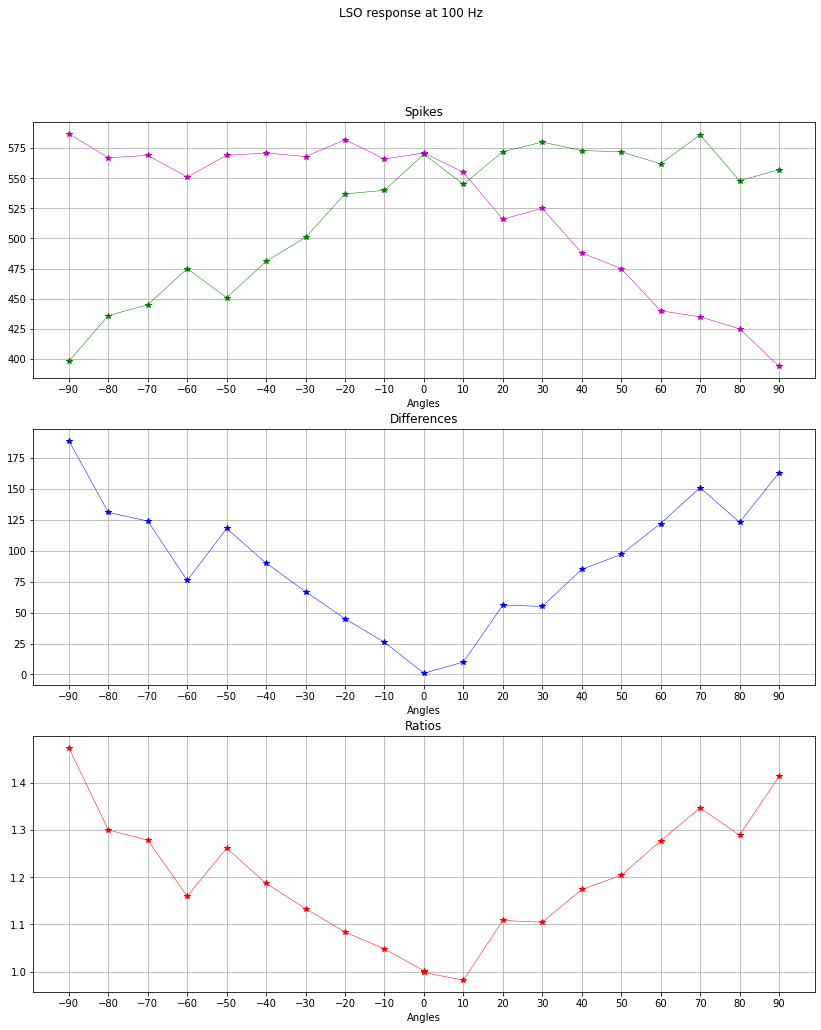

In [17]:
plt.figure(figsize=(14,16))
plt.suptitle("LSO response at 100 Hz")

plt.subplot(3,1,1)
plt.plot(angles,np.loadtxt('data_ILDs_new/r_s_100_1000', delimiter=','), '-*', linewidth = 0.5, color = 'g')
plt.plot(angles,np.loadtxt('data_ILDs_new/l_s_100_1000', delimiter=','), '-*', linewidth = 0.5, color = 'm')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Spikes")

plt.subplot(3,1,2)
plt.plot(angles,abs(np.loadtxt('data_ILDs_new/diff_100_1000', delimiter=',')), '-*', linewidth = 0.5, color = 'b')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Differences")

plt.subplot(3,1,3)
ratios = np.loadtxt('data_ILDs_new/ratio_100_1000', delimiter=',')
plt.plot(angles[0:10], 1/ratios[0:10], '-*', linewidth = 0.5, color = 'r')
plt.plot(angles[9:19],ratios[9:19], '-*', linewidth = 0.5, color = 'r')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Ratios")

Text(0.5, 1.0, 'Ratios')

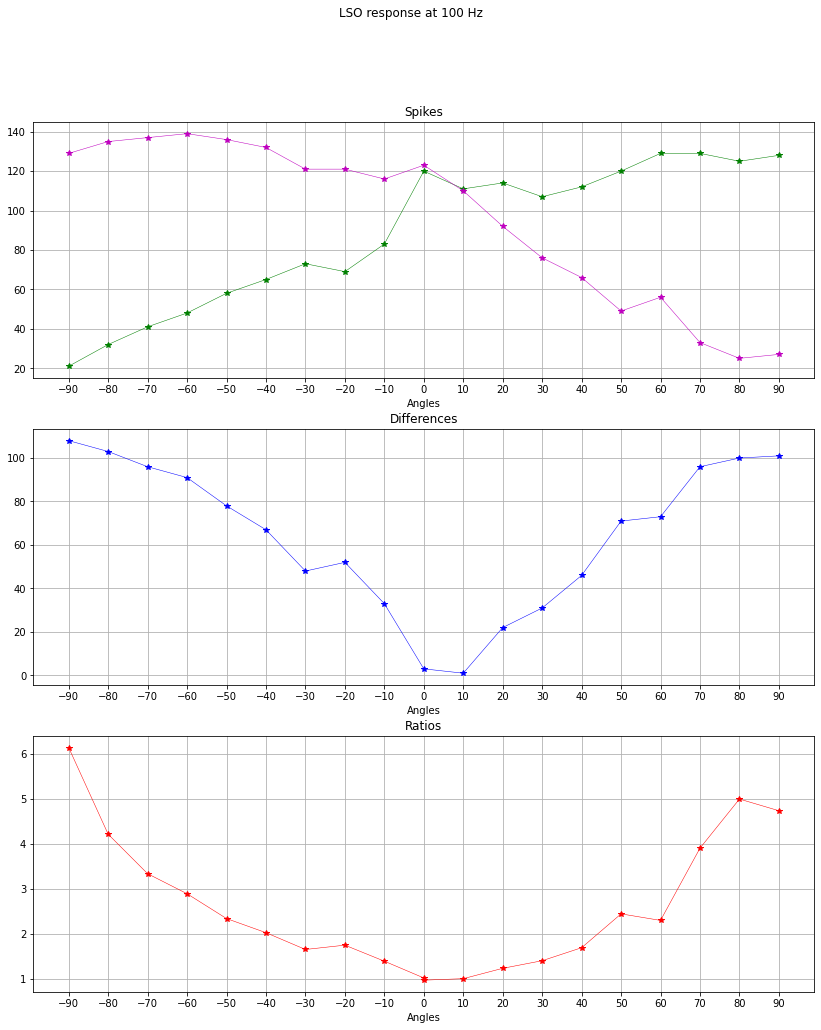

In [16]:
plt.figure(figsize=(14,16))
plt.suptitle("LSO response at 100 Hz")

plt.subplot(3,1,1)
plt.plot(angles,np.loadtxt('data_ILDs/r_s_100_1000', delimiter=','), '-*', linewidth = 0.5, color = 'g')
plt.plot(angles,np.loadtxt('data_ILDs/l_s_100_1000', delimiter=','), '-*', linewidth = 0.5, color = 'm')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Spikes")

plt.subplot(3,1,2)
plt.plot(angles,abs(np.loadtxt('data_ILDs/diff_100_1000', delimiter=',')), '-*', linewidth = 0.5, color = 'b')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Differences")

plt.subplot(3,1,3)
ratios = np.loadtxt('data_ILDs/ratio_100_1000', delimiter=',')
plt.plot(angles[0:10], 1/ratios[0:10], '-*', linewidth = 0.5, color = 'r')
plt.plot(angles[9:19],ratios[9:19], '-*', linewidth = 0.5, color = 'r')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Ratios")

In [ ]:
plt.figure(figsize=(14,16))
plt.suptitle("LSO response at 1000 Hz")

plt.subplot(3,1,1)
plt.plot(angles,np.loadtxt('data_ILDs/r_s_1000_1000', delimiter=','), '-*', linewidth = 0.5, color = 'g')
plt.plot(angles,np.loadtxt('data_ILDs/l_s_1000_1000', delimiter=','), '-*', linewidth = 0.5, color = 'm')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Spikes")

plt.subplot(3,1,2)
plt.plot(angles,abs(np.loadtxt('data_ILDs/diff_1000_1000', delimiter=',')), '-*', linewidth = 0.5, color = 'b')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Differences")

plt.subplot(3,1,3)
ratios = np.loadtxt('data_ILDs/ratio_1000_1000', delimiter=',')
for i in range(10):
    if(ratios[i] != 0):
        ratios[i] = 1/ratios[i]
plt.plot(angles,ratios, '-*', linewidth = 0.5, color = 'r')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Ratios")

In [ ]:
plt.figure(figsize=(14,16))
plt.suptitle("LSO response at 10000 Hz")

plt.subplot(3,1,1)
plt.plot(angles,np.loadtxt('data_ILDs/r_s_10000_1000', delimiter=','), '-*', linewidth = 0.5, color = 'g')
plt.plot(angles,np.loadtxt('data_ILDs/l_s_10000_1000', delimiter=','), '-*', linewidth = 0.5, color = 'm')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Spikes")

plt.subplot(3,1,2)
plt.plot(angles,abs(np.loadtxt('data_ILDs/diff_10000_1000', delimiter=',')), '-*', linewidth = 0.5, color = 'b')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Differences")

plt.subplot(3,1,3)
ratios = np.loadtxt('data_ILDs/ratio_10000_1000', delimiter=',')
for i in range(10):
    if(ratios[i] != 0):
        ratios[i] = 1/ratios[i]
plt.plot(angles,ratios, '-*', linewidth = 0.5, color = 'r')
plt.xticks(ticks = angles)
plt.xlabel("Angles")
plt.grid()
plt.title("Ratios")

In [ ]:
data = np.loadtxt('data_ILDs/ratio_20_49ch', delimiter=',')
data1 = np.loadtxt('data_ILDs/ratio_20_1000', delimiter=',')

In [ ]:
data

In [ ]:
data1

In [ ]:
data-data1